In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

In [2]:
!pip install curlyBrace

ERROR: Could not find a version that satisfies the requirement curlyBrace (from versions: none)
ERROR: No matching distribution found for curlyBrace


In [3]:
class Brownian():
    """
    A Brownian motion class
    """
    def __init__(self,x0=0):
        self.x0 = float(x0)
    
    def gen_random_walk(self,n_step=100):
        """Generate motion by random walk        
        Arguments:
            n_step: Number of steps            
        Returns:
            A NumPy array with `n_steps` points
        """        
        w = np.ones(n_step)*self.x0        
        for i in range(1,n_step):
            # Sampling from the Normal distribution with probability 1/2
            yi = np.random.choice([1,-1])
            # Weiner process
            w[i] = w[i-1]+(yi/np.sqrt(n_step))        
        return w
    
    def gen_normal(self,n_step=100):
        """Generate motion by drawing from the Normal distribution        
        Arguments:
            n_step: Number of steps            
        Returns:
            A NumPy array with `n_steps` points
        """
        w = np.ones(n_step)*self.x0        
        for i in range(1,n_step):
            # Sampling from the Normal distribution
            yi = np.random.normal()
            # Weiner process
            w[i] = w[i-1]+(yi/np.sqrt(n_step))        
        return w
    
    def stock_price(
                    self,
                    s0=100,
                    mu=0.2,
                    sigma=0.68,
                    deltaT=52,
                    dt=0.1
                    ):
        """
        Models a stock price S(t) using the Weiner process W(t) as
        `S(t) = S(0).exp{(mu-(sigma^2/2).t)+sigma.W(t)}`
        
        Arguments:
            s0: Iniital stock price, default 100
            mu: 'Drift' of the stock (upwards or downwards), default 1
            sigma: 'Volatility' of the stock, default 1
            deltaT: The time period for which the future prices are computed, default 52 (as in 52 weeks)
            dt (optional): The granularity of the time-period, default 0.1
        
        Returns:
            s: A NumPy array with the simulated stock prices over the time-period deltaT
        """
        n_step = int(deltaT/dt)
        time_vector = np.linspace(0,deltaT,num=n_step)
        # Stock variation
        stock_var = (mu-(sigma**2/2))*time_vector
        # Forcefully set the initial value to zero for the stock price simulation
        self.x0=0
        # Weiner process (calls the `gen_normal` method)
        weiner_process = sigma*self.gen_normal(n_step)
        # Add two time series, take exponent, and multiply by the initial stock price
        s = s0*(np.exp(stock_var+weiner_process))
        
        return s

In [4]:

def get_ohlc(ref, sub):
    '''
    fn: get ohlc from custom bars
    
    # args
        ref : reference pandas series with all prices
        sub : custom tick pandas series
    # returns
        tick_df : dataframe with ohlc values
    '''
    ohlc = []
    for i in tqdm(range(sub.index.shape[0]-1)):
        start,end = sub.index[i], sub.index[i+1]
        tmp_ref = ref.loc[start:end]
        max_px, min_px = tmp_ref.max(), tmp_ref.min()
        o,h,l,c = sub.iloc[i], max_px, min_px, sub.iloc[i+1]
        ohlc.append((end,start,o,h,l,c))
    cols = ['End','Start','Open','High','Low','Close']
    return (pd.DataFrame(ohlc,columns=cols))

## uncomment below to run (takes about 5-6 mins on my machine)
#tick_bars_ohlc = get_ohlc(ref, sub)
#cprint(tick_bars_ohlc)

#outfp = PurePath(data_dir/'processed'/'tick_bars_ohlc.parq')
#tick_bars_ohlc.to_parquet(outfp)

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
styleFiles = os.listdir(mpl.get_configdir())
styleFileIdx = 0

plt.style.use(os.path.join(mpl.get_configdir(), styleFiles[styleFileIdx]))
figures_destination = '/home/ak/Documents/Research/Papers/figures'

In [6]:
b = Brownian(20)
# initial value of 20 and using random walk

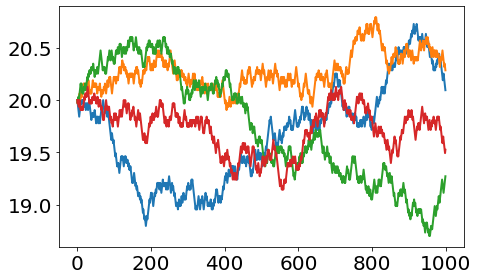

In [8]:
for i in range(4):
    plt.plot(b.gen_random_walk(1000))
plt.show()

In [9]:
b = Brownian(20)
# initial value of 20 and using normal disribution

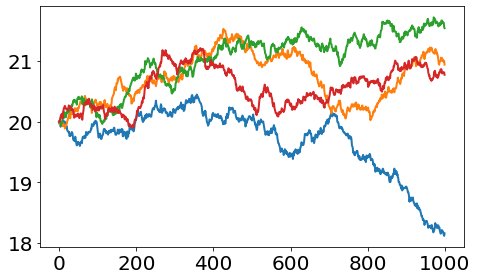

In [10]:
for i in range(4):
    plt.plot(b.gen_normal(1000))
plt.show()

In [90]:
## Stock Price Simulation

In [11]:
def plot_stock_price(mu,sigma):
    """
    Plots stock price for multiple scenarios
    """
    plt.figure(figsize=(9,4))
    for i in range(5):
        plt.plot(b.stock_price(mu=mu,
                               sigma=sigma,
                               dt=0.1))
    plt.legend(['Scenario-'+str(i) for i in range(1,6)],
               loc='upper left')
    plt.hlines(y=100,xmin=0,xmax=520,
               linestyle='--',color='k')
    plt.show()

findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.


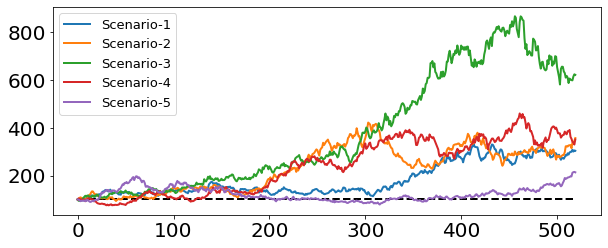

In [12]:
plot_stock_price(mu=0.3,sigma=0.75)

In [11]:
mu=0.2 
sigma=0.65
df = pd.DataFrame()
df =pd.DataFrame(b.stock_price(mu=mu, sigma=sigma, dt=0.2)).pct_change()

In [13]:
def draw_brace(ax, xspan, yy, text):
    """Draws an annotated brace on the axes."""
    xmin, xmax = xspan
    xspan = xmax - xmin
    ax_xmin, ax_xmax = ax.get_xlim()
    xax_span = ax_xmax - ax_xmin

    ymin, ymax = ax.get_ylim()
    yspan = ymax - ymin
    resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
    beta = 300./xax_span # the higher this is, the smaller the radius

    x = np.linspace(xmin, xmax, resolution)
    x_half = x[:int(resolution/2)+1]
    y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
    y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
    y = yy + (.05*y - .01)*yspan # adjust vertical position

    ax.autoscale(False)
    ax.plot(x, y, color='black', lw=1)

    ax.text((xmax+xmin)/2., yy+.07*yspan, text, ha='center', va='bottom')
def bracket(ax, pos=[0,0], scalex=1, scaley=1, text="",textkw = {}, linekw = {}):
    x = np.array([0, 0.05, 0.45,0.5])
    y = np.array([0,-0.01,-0.01,-0.02])
    x = np.concatenate((x,x+0.5)) 
    y = np.concatenate((y,y[::-1]))
    ax.plot(x*scalex+pos[0], y*scaley+pos[1], clip_on=False, 
            transform=ax.get_xaxis_transform(), **linekw)
    ax.text(pos[0]+0.5*scalex, (y.min()-0.01)*scaley+pos[1], text, 
                transform=ax.get_xaxis_transform(),
                ha="center", va="top", **textkw)


In [14]:
mu=0.22
sigma=0.65
df = pd.DataFrame()
df =pd.DataFrame(b.stock_price(mu=mu, sigma=sigma, dt=0.1))

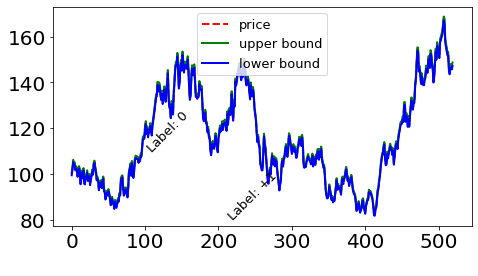

In [15]:

plt.plot(df[0], label= 'price',linestyle='--', color= 'r')

# plt.plot(df[0].rolling(window=25).mean(), color= 'r', label='moving average',linestyle='--')
plt.plot(df[0]*1.005, color= 'g', label='upper bound')
plt.plot(df[0]*0.995, color= 'blue', label='lower bound')
t1 =plt.annotate('Label: +1', xy = (210,80), size = 13, rotation = 45)
t2 =plt.annotate('Label: -1', xy = (140,60), size = 13, rotation = 45)
t3 = plt.annotate('Label: 0', xy = (100,110), size = 13, rotation = 45)

plt.legend()
plt.show()



In [16]:
np.log(df[0].pct_change()).fillna(0)

/home/ak/Envs/resrPyth3/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0      0.000000
1     -3.626862
2     -3.507127
3      0.000000
4     -5.834044
         ...   
515    0.000000
516   -3.906622
517   -6.855126
518    0.000000
519   -4.515470
Name: 0, Length: 520, dtype: float64

/home/ak/Envs/resrPyth3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.


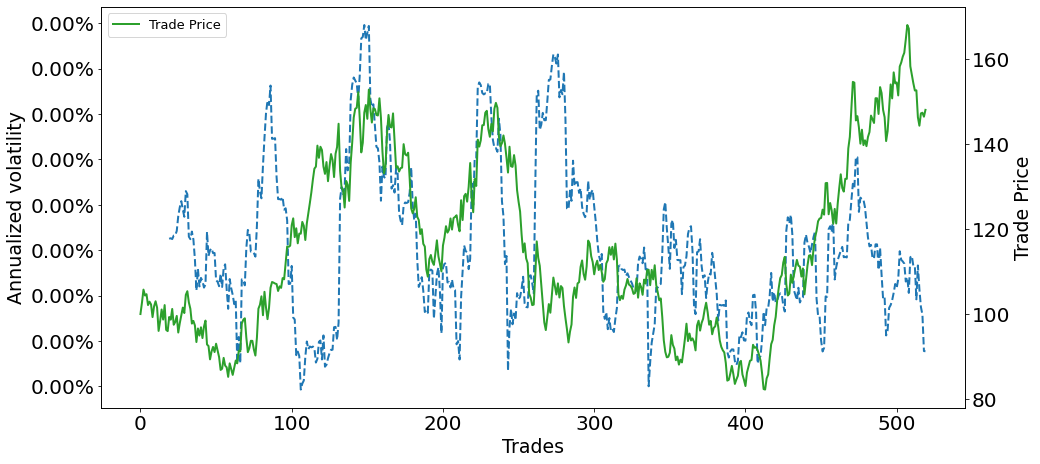

In [17]:
import matplotlib.pyplot as plt
# compute volatility using Pandas rolling and std methods, the trading days is set to 252 days
TRADING_DAYS = 20
returns = np.log(df[0]/df[0].shift(1)).fillna(0)
returns.fillna(0, inplace=True)
volatility = returns.rolling(window=TRADING_DAYS).std()#*np.sqrt(TRADING_DAYS)

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(1, 1, 1)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Trade Price')  # we already handled the x-label with ax1
ax2.plot(df[0], color=color, label= 'Trade Price')
# ax1.plot(df[0])
ax1.plot(volatility, linestyle = '--', label ='Ann.Vol')
ax1.set_xlabel('Trades')
ax1.set_ylabel('Annualized volatility')
plt.legend()
# manipulate
vals = ax1.get_yticks()/1000
ax1.set_yticklabels(['{:,.02%}'.format(x) for x in vals])
plt.legend()
# vol_title = 'annualised_volatility_20_trades.png'
# plt.savefig(os.path.join(figures_destination, vol_title))

plt.show()

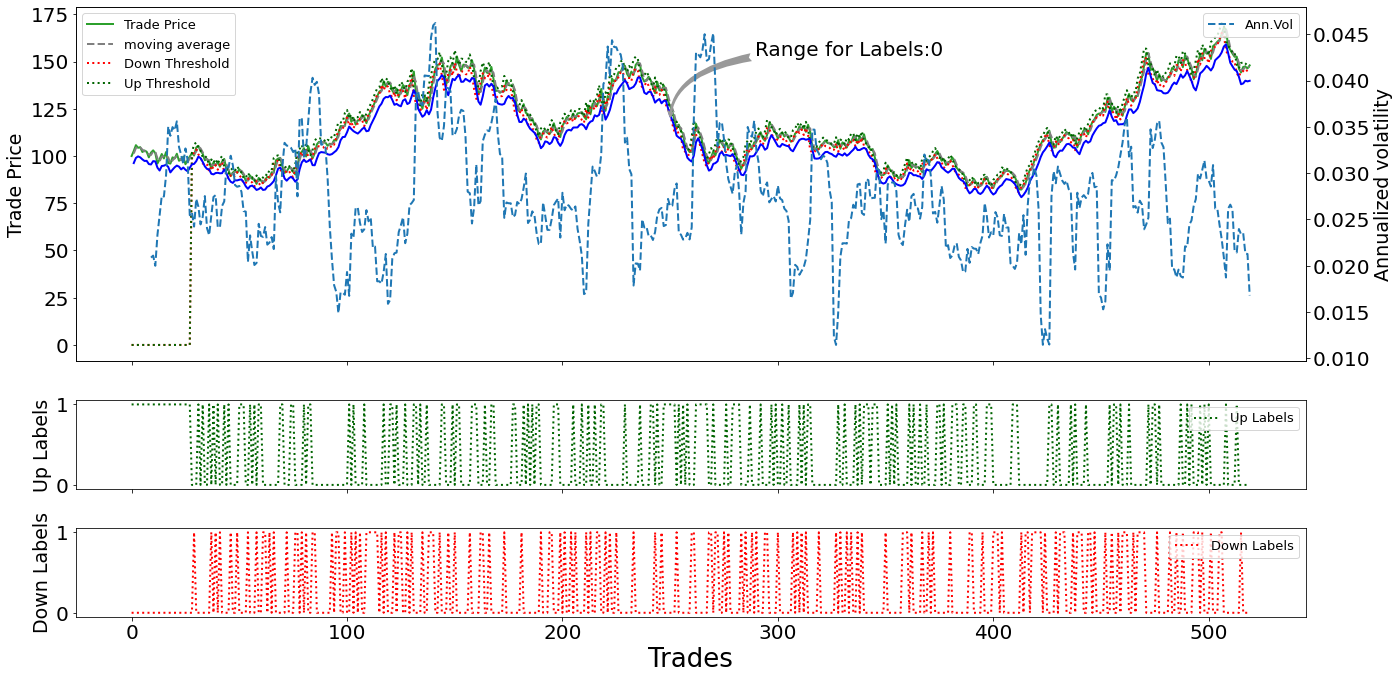

In [26]:

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 10), sharex= True,  gridspec_kw={'height_ratios': [4, 1, 1]})
TRADING_DAYS = 10
returns = np.log(df[0]/df[0].shift(1)).fillna(0)
returns.fillna(0, inplace=True)
volatility = returns.rolling(window=TRADING_DAYS).std()#*np.sqrt(TRADING_DAYS)
downFactor = 0.62
upFactor = 0.56
# ax1 = fig.add_subplot(1, 1, 1)
ax1.set_ylabel('Trade Price')  # we already handled the x-label with ax1
ax1.plot(df[0], color=color, label= 'Trade Price')
ax1.plot(df[0].rolling(window=2).mean(), color= 'grey', label='moving average',linestyle='--')
ax1.plot((df[0].shift(-1)*(1-downFactor*volatility.rolling(window=20).mean()).fillna(0)), label='Down Threshold', linestyle = ':', color='red')
ax1.plot((df[0].shift(-1)*(1+upFactor*volatility.rolling(window=20).mean()).fillna(0)), label='Up Threshold', linestyle = ':', color='darkgreen')
ax1.legend()
ax1.plot(df[0].rolling(window=2).mean()*0.95, color= 'blue', label='lower bound')
ax4 = ax1.twinx()
ax1.annotate('Range for Labels:0',
            xy=(250., 119), xycoords='data',
            xytext=(85, 65), textcoords='offset points',
            size=20,
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.6", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))
ax4.plot(volatility, linestyle = '--', label ='Ann.Vol')
ax4.legend()
ax4.set_ylabel('Annualized volatility')
ax3.set_xlabel('Trades', fontsize=26)
ax3.plot((df[0]- df[0].shift(-1)*(1-downFactor*volatility.rolling(window=20).mean()).fillna(0)<0), label='Down Labels', linestyle = ':', color='red')
ax2.set_ylabel('Up Labels')
ax3.set_ylabel('Down Labels')
ax2.plot((df[0]- df[0].shift(-1)*(1+upFactor*volatility.rolling(window=20).mean()).fillna(0)>0)*1, label='Up Labels', linestyle = ':', color='darkgreen')
ax3.legend()
ax2.legend()
title = 'simpleLabelstylisedExamplewithMA.png'
plt.savefig(os.path.join(figures_destination, title))




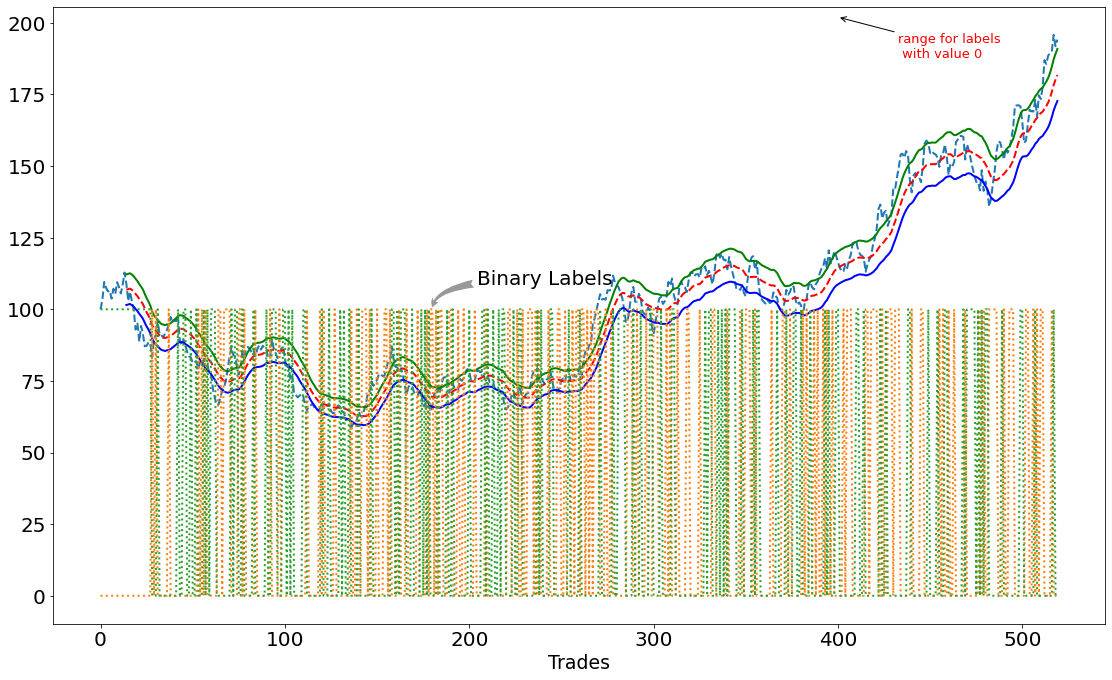

In [103]:

fig, ax = plt.subplots(figsize=(16, 10))
plt.plot(df[0], label= 'price',linestyle='--')
ax.plot(df[0].rolling(window=15).mean(), color= 'r', label='moving average',linestyle='--')
ax.plot(df[0].rolling(window=15).mean()*1.05, color= 'g', label='upper bound')
ax.plot(df[0].rolling(window=15).mean()*0.95, color= 'blue', label='lower bound')
# ax.annotate(
#     ' threshold for labels\n with value +1', color = 'green',
#     xy=(55, 135), xycoords='data',
#     xytext=(-30,60), textcoords='offset points',
#     arrowprops=dict(arrowstyle="->"), fontsize = 13)
# ax.annotate(
#     'threshold for labels\n with value -1', color = 'blue',
#     xy=(400, 165), xycoords='data',
#     xytext=(-54, -70), textcoords='offset points',
#     arrowprops=dict(arrowstyle="->"), fontsize = 13)

ax.annotate(
    'range for labels\n with value 0', color= 'red',
    xy=(400, 202), xycoords='data',
    xytext=(60, -40), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"), fontsize = 13)
plt.xlabel('Trades')
plt.plot((df[0]- df[0].shift(-1)*(1-downFactor*volatility.rolling(window=20).mean()).fillna(0)<0)*100, label='Down Labels', linestyle = ':')
plt.plot((df[0]- df[0].shift(-1)*(1+upFactor*volatility.rolling(window=20).mean()).fillna(0)>0)*100, label='Up Labels', linestyle = ':')


ax.annotate('Binary Labels',
            xy=(180., 100), xycoords='data',
            xytext=(45, 25), textcoords='offset points',
            size=20,
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.6", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))
title = 'simpleLabelstylisedExamplewithMA.png'

plt.savefig(os.path.join(figures_destination, title))



Text(-50, -60, 'lower threshold \n based on previous trade')

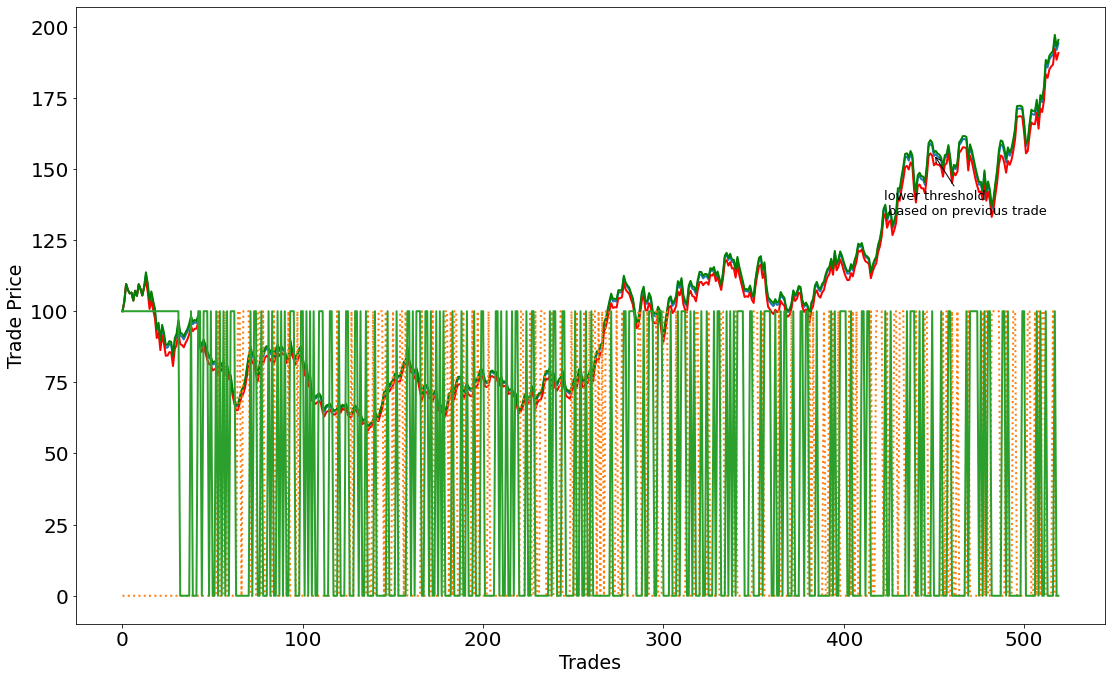

In [20]:
TRADING_DAYS = 10
returns = np.log(df[0]/df[0].shift(1)).fillna(0)
returns.fillna(0, inplace=True)
volatility = returns.rolling(window=TRADING_DAYS).std().rolling(window=5).mean()
#### ---- ####
fig, ax = plt.subplots(figsize=(16, 10))
plt.plot(df[0], label= 'price',linestyle='-')
downFactor = 0.72
upFactor = 0.26
plt.xlabel('Trades') 
plt.ylabel('Trade Price')
ax.plot(df[0]*(1-downFactor*volatility.fillna(0)), color ='red', label = 'lower bound', linestyle = '-')
ax.plot(df[0]*(1+upFactor*volatility.fillna(0)), color ='green', label = 'upper bound', linestyle = '-')
plt.plot((df[0]- df[0].shift(-1)*(1-downFactor*volatility.rolling(window=20).mean()).fillna(0)<0)*100, label='Down Labels', linestyle = ':')
plt.plot((df[0]- df[0].shift(-1)*(1+upFactor*volatility.rolling(window=20).mean()).fillna(0)>0)*100, label='Up Labels', linestyle = '-')
ax.annotate(
    'lower threshold \n based on previous trade',
    xy=(450, 155), xycoords='data',
    xytext=(-50, -60), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"), fontsize = 13)

# ax.annotate(
#     'upper threshold \n based on previous trade',
#     xy=(160, 250), xycoords='data',
#     xytext=(-30, 30), textcoords='offset points',
#     arrowprops=dict(arrowstyle="->"), fontsize = 13)
# ax.annotate('Binary Labels',
#             xy=(140., 100), xycoords='data',
#             xytext=(40, 25), textcoords='offset points',
#             size=20,
#             # bbox=dict(boxstyle="round", fc="0.8"),
#             arrowprops=dict(arrowstyle="fancy",
#                             fc="0.6", ec="none",
#                             patchB=el,
#                             connectionstyle="angle3,angleA=0,angleB=-90"))
# plt.legend()
# title = 'EIP_stylised_example_with_labels.png'
# plt.savefig(os.path.join(figures_destination, title))

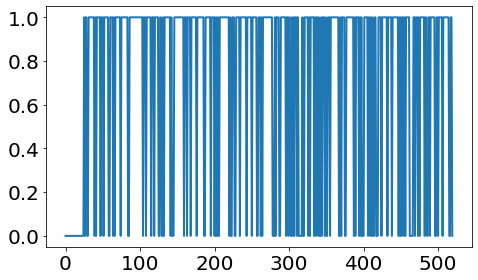

In [62]:
plt.plot(df[0][25:]- df[0].shift(-1)*(1-downFactor*volatility.rolling(window=2).mean()).fillna(0)>0, label='Label indicator function')


NameError: name 'el' is not defined

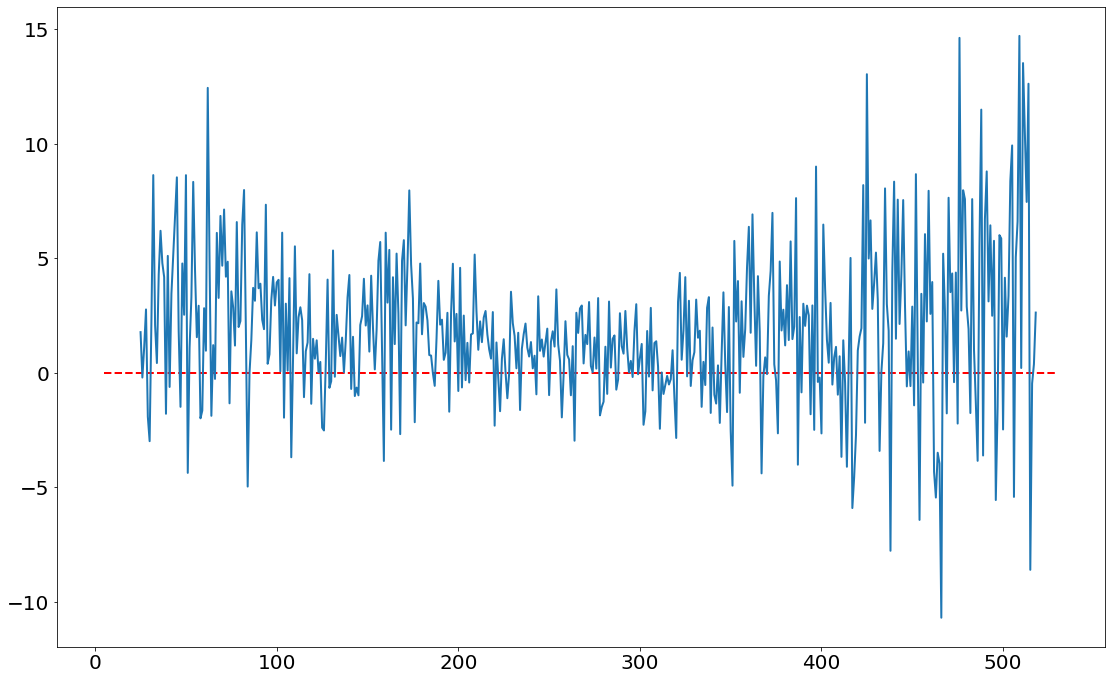

In [63]:
fig, ax = plt.subplots(figsize=(16, 10))
_ = ax.plot(df[0][25:]- df[0].shift(-1)*(1-downFactor*volatility.rolling(window=2).mean()).fillna(0), label='Label indicator function')

_ =ax.hlines(xmin=5, xmax=530, y=0, color='r', linestyles='--')
_ =ax.annotate('labels',
            xy=(300., -4.5), xycoords='data',
            xytext=(55, 0), textcoords='offset points',
            size=20, va="center",
            bbox=dict(boxstyle="round", fc=(1.0, 0.7, 0.7), ec="none"),
            arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                            fc=(1.0, 0.7, 0.7), ec="none",
                            patchA=None,
                            patchB=el,
                            relpos=(0.2, 0.5)))
_ =plt.title('Down Threshold Labels')
_=plt.legend()

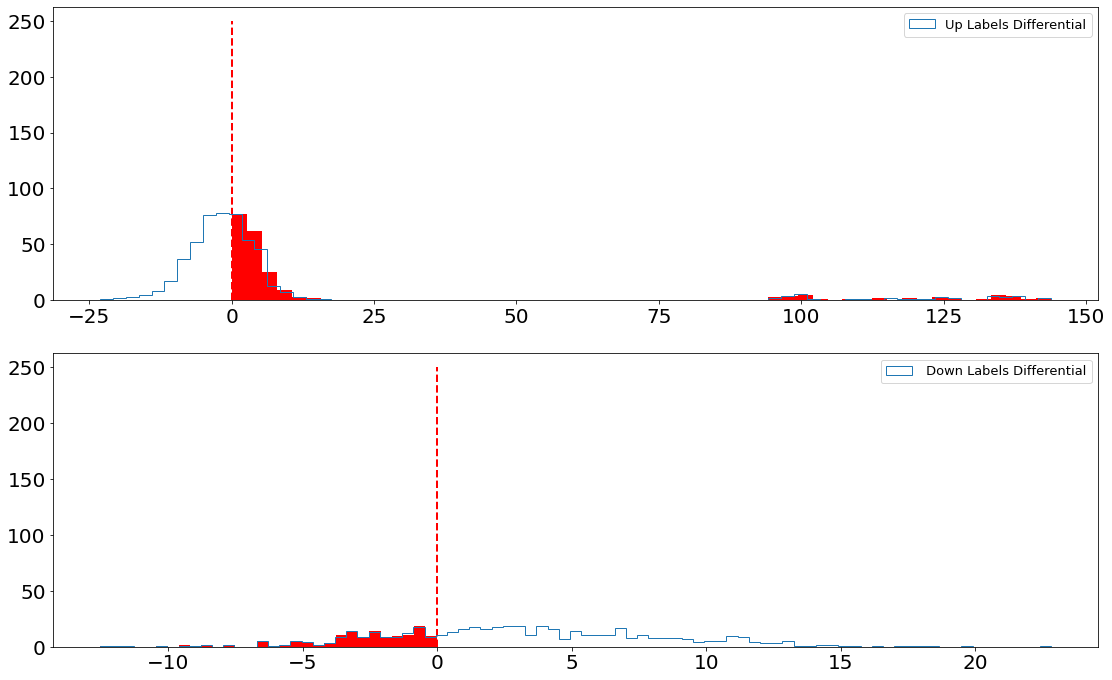

In [276]:
f, (ax1, ax2) = plt.subplots(2, sharex=False, sharey=True,figsize=(16,10))
down_differential = df[0][25:]- df[0].shift(-1)*(1-downFactor*volatility.rolling(window=2).mean()).fillna(0)
ax2.hist(down_differential,bins =85,histtype='step', label =' Down Labels Differential')
ax2.vlines(x= 0, ymin =0, ymax=250, linestyle = '--', color 
           = 'red')
mask =  (down_differential <= 0)

ax2.hist(down_differential[mask],bins = 30,histtype='bar', color='red', lw=0)
ax2.legend()


up_differential = df[0]- df[0].shift(-1)*(1+upFactor*volatility.rolling(window=20).mean()).fillna(0)
up_mask =  (up_differential >= 0)

ax1.hist(up_differential,bins =74,histtype='step', label ='Up Labels Differential')
ax1.hist(up_differential[up_mask],bins = 55,histtype='bar', color='red', lw=0)
ax1.vlines(x= 0, ymin =0, ymax=250, linestyle = '--', color = 'red')
ax1.legend()
histo_title = 'differential_histograms.png'
plt.savefig(os.path.join(figures_destination, histo_title))
plt.show()


In [ ]:
down_differential = df[0][25:]- df[0].shift(-1)*(1-downFactor*volatility.rolling(window=2).mean()).fillna(0)
_=plt.hist(down_differential, bins =30)
_= plt.vlines(x= 0, ymin =0, ymax=250, linestyle = '--', color = 'red')

In [64]:

_ = ax.plot(df[0]- df[0].shift(-1)*(upFactor*volatility.rolling(window=2).mean()).fillna(0), label='Label indicator function')

_ =ax.hlines(xmin=5, xmax=530, y=0, color='r', linestyles='--')
_ =ax.annotate('labels',
            xy=(300., -4.5), xycoords='data',
            xytext=(55, 0), textcoords='offset points',
            size=20, va="center",
            bbox=dict(boxstyle="round", fc=(1.0, 0.7, 0.7), ec="none"),
            arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                            fc=(1.0, 0.7, 0.7), ec="none",
                            patchA=None,
                            patchB=el,
                            relpos=(0.2, 0.5)))
_ =plt.title('Upward Threshold Labels')
_=plt.legend()

NameError: name 'el' is not defined

NameError: name 'el' is not defined

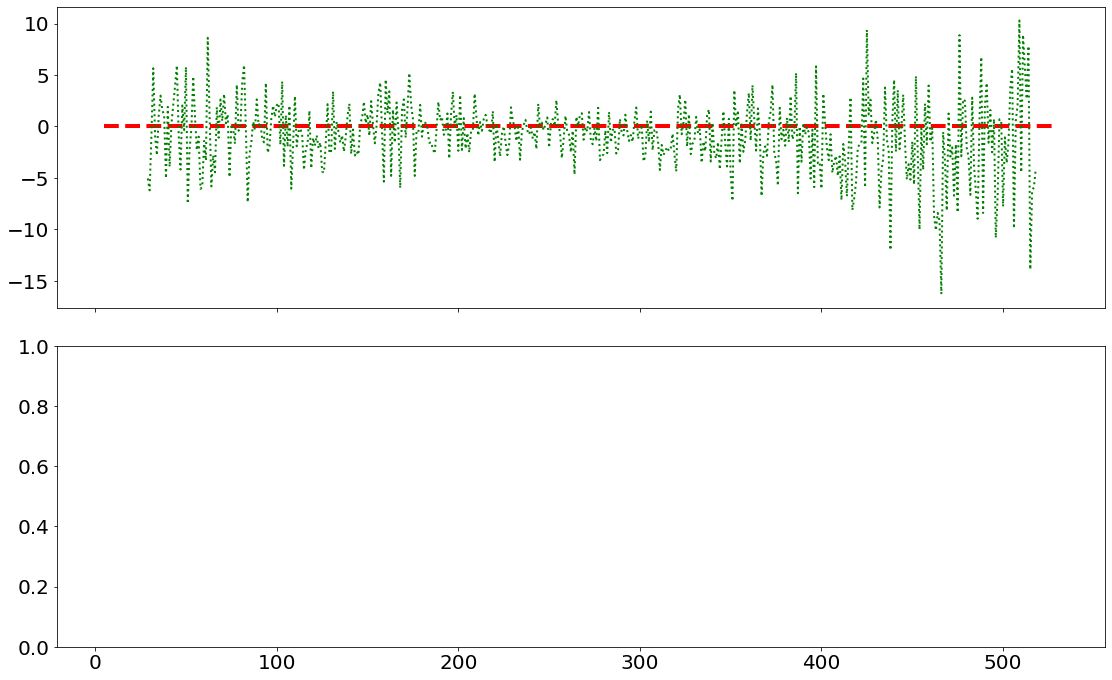

In [65]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 10), sharex = True)
ax1.plot(df[0][29:]-df[0].shift(-1)*(1+upFactor*volatility.rolling(window=5).mean().fillna(0)), color='g', linestyle =':', label ='label indicator function')
ax1.hlines(xmin=5, xmax=530, y=0, color='r', linestyles='--', linewidth =4)
ax1.annotate('Positive values of the differential, \n create binary labels of +1',
            xy=(300., 4.5), xycoords='data',
            xytext=(55, 0), textcoords='offset points',
            size=20, va="center",
            bbox=dict(boxstyle="round", fc=(1.0, 0.7, 0.7), ec="none"),
            arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                            fc=(1.0, 0.7, 0.7), ec="none",
                            patchA=None,
                            patchB=el,
                            relpos=(0.2, 0.5)))
_= ax1.annotate('This boundary is where the current price exceeds \n the vol-adjusted threshold of the previous price or the moving average',
            xy=(20., 0), xycoords='data',
            xytext=(0, -70), textcoords='offset points',
            size=20,
            bbox=dict(boxstyle="round",
                      fc=(1.0, 0.7, 0.7),
                      ec=(1., .5, .5)),
            arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                            fc=(1.0, 0.7, 0.7), ec=(1., .5, .5),
                            patchA=None,
                            patchB=el,
                            relpos=(0.2, 0.8),
                            connectionstyle="arc3,rad=-0.1"))
ax1.set_title('Upward Threshold Labels')
_=plt.legend()


_ = ax2.plot(df[0][54:]- df[0].shift(-1)*(1-downFactor*volatility.rolling(window=2).mean()).fillna(0),color='blue',linestyle=':', label='Label indicator function')

_ =ax2.hlines(xmin=5, xmax=530, y=0, color='r', linestyles='--', linewidth =4)
_ =ax2.annotate('labels of -1 given -ve differential',
            xy=(300., -4.5), xycoords='data',
            xytext=(55, 0), textcoords='offset points',
            size=20, va="center",
            bbox=dict(boxstyle="round", fc=(1.0, 0.7, 0.7), ec="none"),
            arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                            fc=(1.0, 0.7, 0.7), ec="none",
                            patchA=None,
                            patchB=el,
                            relpos=(0.2, 0.5)))
ax2.set_title('Down Threshold Labels')
_=plt.legend()
title = 'thresholdsInOne.png'
plt.savefig(os.path.join(figures_destination, title))

In [66]:
df[0]

0      100.000000
1      106.012372
2      110.267351
3      113.903583
4      117.308765
          ...    
515    191.488574
516    204.053296
517    208.813082
518    213.164265
519    215.617503
Name: 0, Length: 520, dtype: float64

In [67]:
df['previous_price'] =df.shift(1)

In [68]:
upper_threshold = 0.055
df['UpperThreshold'] = df.previous_price*(1+upper_threshold)
df['LowerThreshold'] = df.previous_price*(1-upper_threshold)



In [69]:
df= df.rename(columns ={0:'price'})

In [70]:
df = df.dropna()
df['upperLabel'] = df.price - df.UpperThreshold
df['lowerLabel'] = df.price - df.LowerThreshold


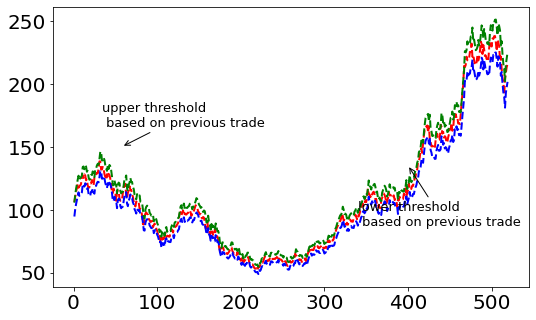

In [71]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(df['price'], label= 'price',linestyle='--', color='red')
plt.plot(df['UpperThreshold'], label= 'price',linestyle='--', color ='green')
plt.plot(df['LowerThreshold'], label= 'price',linestyle='--', color ='blue')
ax.annotate(
    'lower threshold \n based on previous trade',
    xy=(400, 135), xycoords='data',
    xytext=(-50, -60), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"), fontsize = 13)

ax.annotate(
    'upper threshold \n based on previous trade',
    xy=(58, 150), xycoords='data',
    xytext=(-20, 20), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"), fontsize = 13)
title = 'EIP_stylised_example.png'
plt.savefig(os.path.join(figures_destination, title))


NameError: name 'el' is not defined

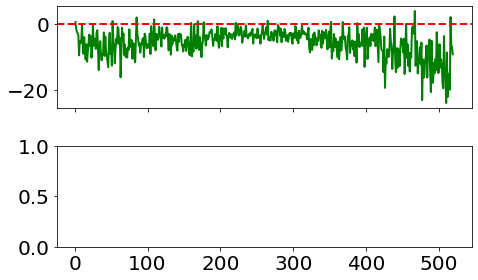

In [72]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)

ax1.plot(df.price - df.UpperThreshold, color ='green')
ax1.axhline(y=0.0, color='r', linestyle='--', label =' Threshold')

ax1.annotate('label',
            xy=(207., 2.5), xycoords='data',
            xytext=(55, 0), textcoords='offset points',
            size=20, va="center",
            bbox=dict(boxstyle="round", fc=(1.0, 0.7, 0.7), ec="none"),
            arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                            fc=(1.0, 0.7, 0.7), ec="none",
                            patchA=None,
                            patchB=el,
                            relpos=(0.2, 0.5)))

ax2.plot(df.price-df.LowerThreshold, color='blue')
ax2.axhline(y=0.0, color='r', linestyle='--', label =' Threshold')
plt.legend()
ax2.annotate('label',
            xy=(300., -4.5), xycoords='data',
            xytext=(55, 0), textcoords='offset points',
            size=20, va="center",
            bbox=dict(boxstyle="round", fc=(1.0, 0.7, 0.7), ec="none"),
            arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                            fc=(1.0, 0.7, 0.7), ec="none",
                            patchA=None,
                            patchB=el,
                            relpos=(0.2, 0.5)))

title = 'thresholdsInOne.png'
plt.savefig(os.path.join(figures_destination, title))

#plt.plot(df.price-df.LowerThreshold, color='red')

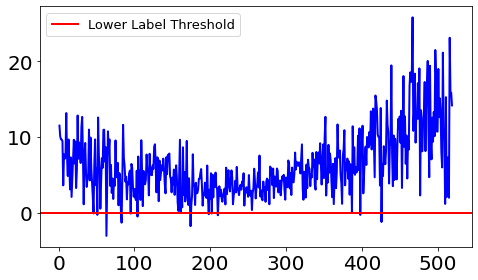

In [73]:
plt.plot(df.price-df.LowerThreshold, color='blue')
plt.axhline(y=0.0, color='r', linestyle='-', label ='Lower Label Threshold')
title = 'simpleLabelstylisedExamplewithPIT_lowerThreshold.png'
plt.legend()
plt.savefig(os.path.join(figures_destination, title))

#plt.plot(df.price-df.LowerThreshold, color='red')

In [74]:
df['2dma'] = df['price'].rolling(window=2, center=False).mean()

## Apply labels
# df['label'] = 'out of bounds'
df.loc[abs(df['2dma'] - df['price']) <= upper_threshold, 'label'] = 'less than threshold'
df.loc[abs(df['price']- df['2dma'] ) >= upper_threshold, 'label'] = 'higher than threshold'



# ## Convert labels to colors
label2color = {
    'out of bounds': 'yellow',
    'less than threshold': 'red',
    'higher than threshold': 'green'}

df['color'] = df['label'].apply(lambda label: label2color[label])

# Create plot
fig, ax = plt.subplots()

def gen_repeating(s):
    """Generator: groups repeated elements in an iterable
    E.g.
        'abbccc' -> [('a', 0, 0), ('b', 1, 2), ('c', 3, 5)]
    """
    i = 0
    while i < len(s):
        j = i
        while j < len(s) and s[j] == s[i]:
            j += 1
        yield (s[i], i, j-1)
        i = j

# ## Add px_last lines
for color, start, end in gen_repeating(df['color']):
    print(start)
#     if start > : # make sure lines connect
#         start -= 1
#     idx = df.index[start:end+1]
#     df.loc[idx, 'price'].plot(ax=ax, color=color, label='')

# ## Add 50dma and 200dma lines
# df['50dma'].plot(ax=ax, color='k', ls='--', label='MA$_{50}$')
# df['200dma'].plot(ax=ax, color='b', ls='--', label='MA$_{200}$')

# ## Get artists and labels for legend and chose which ones to display
# handles, labels = ax.get_legend_handles_labels()

# ## Create custom artists
# g_line = plt.Line2D((0,1),(0,0), color='green')
# y_line = plt.Line2D((0,1),(0,0), color='yellow')
# o_line = plt.Line2D((0,1),(0,0), color='orange')
# r_line = plt.Line2D((0,1),(0,0), color='red')


KeyError: nan

In [75]:
gen_repeating(df['color'])

NameError: name 'gen_repeating' is not defined

KeyError: 0

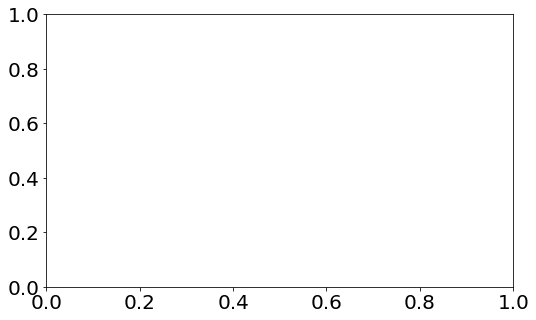

In [76]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(df[0], label= 'price',linestyle='--', color= 'red')
ax.plot(df[0]*1.05, color= 'g', label='upper bound')
ax.plot(df[0]*0.95, color= 'blue', label='lower bound')
ax.annotate(
    ' threshold for labels\n with value +1',
    xy=(50, 110), xycoords='data',
    xytext=(-50, 30), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"), fontsize = 13)
ax.annotate(
    'threshold for labels\n with value -1',
    xy=(85, 100), xycoords='data',
    xytext=(-50, -60), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"), fontsize = 13)

ax.annotate(
    'range for labels\n with value 0',
    xy=(175, 80), xycoords='data',
    xytext=(20, 30), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"), fontsize = 13)
plt.xlabel('Trades')

ax.annotate('lookback\n window', xy=(5, 110),  xycoords='data',
             xytext=(-30, 0), textcoords='offset points',
             size=13, ha='right', va="center",
             bbox=dict(boxstyle="round", alpha=0.1),
             arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=0,angleB=80,rad=20"))
# el = Ellipse((30, 30), 10, 20, facecolor='r', alpha=0.5)
# title = 'simpleLabelstylisedExamplewithMA.png'
# ax.add_artist(el)
# el.set_clip_box(ax.bbox)
# plt.savefig(os.path.join(figures_destination, title))



[(-1.0, 5.0), (-5.0, 3.0)]

findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.


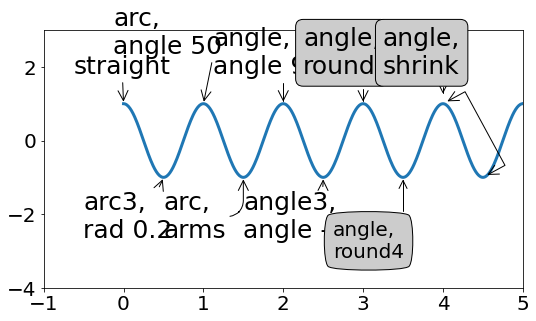

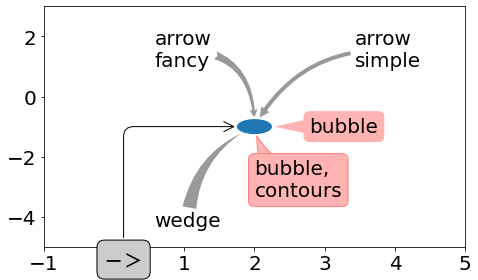

In [77]:
from matplotlib.patches import Ellipse
import numpy as np
from matplotlib.text import OffsetFrom
fig, ax = plt.subplots(figsize=(8, 5))

t = np.arange(0.0, 5.0, 0.01)
s = np.cos(2*np.pi*t)
line, = ax.plot(t, s, lw=3)

ax.annotate(
    'straight',
    xy=(0, 1), xycoords='data',
    xytext=(-50, 30), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))
ax.annotate(
    'arc3,\nrad 0.2',
    xy=(0.5, -1), xycoords='data',
    xytext=(-80, -60), textcoords='offset points',
    arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3,rad=.2"))
ax.annotate(
    'arc,\nangle 50',
    xy=(1., 1), xycoords='data',
    xytext=(-90, 50), textcoords='offset points',
    arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc,angleA=0,armA=50,rad=10"))
ax.annotate(
    'arc,\narms',
    xy=(1.5, -1), xycoords='data',
    xytext=(-80, -60), textcoords='offset points',
    arrowprops=dict(
        arrowstyle="->",
        connectionstyle="arc,angleA=0,armA=40,angleB=-90,armB=30,rad=7"))
ax.annotate(
    'angle,\nangle 90',
    xy=(2., 1), xycoords='data',
    xytext=(-70, 30), textcoords='offset points',
    arrowprops=dict(arrowstyle="->",
                    connectionstyle="angle,angleA=0,angleB=90,rad=10"))
ax.annotate(
    'angle3,\nangle -90',
    xy=(2.5, -1), xycoords='data',
    xytext=(-80, -60), textcoords='offset points',
    arrowprops=dict(arrowstyle="->",
                    connectionstyle="angle3,angleA=0,angleB=-90"))
ax.annotate(
    'angle,\nround',
    xy=(3., 1), xycoords='data',
    xytext=(-60, 30), textcoords='offset points',
    bbox=dict(boxstyle="round", fc="0.8"),
    arrowprops=dict(arrowstyle="->",
                    connectionstyle="angle,angleA=0,angleB=90,rad=10"))
ax.annotate(
    'angle,\nround4',
    xy=(3.5, -1), xycoords='data',
    xytext=(-70, -80), textcoords='offset points',
    size=20,
    bbox=dict(boxstyle="round4,pad=.5", fc="0.8"),
    arrowprops=dict(arrowstyle="->",
                    connectionstyle="angle,angleA=0,angleB=-90,rad=10"))
ax.annotate(
    'angle,\nshrink',
    xy=(4., 1), xycoords='data',
    xytext=(-60, 30), textcoords='offset points',
    bbox=dict(boxstyle="round", fc="0.8"),
    arrowprops=dict(arrowstyle="->",
                    shrinkA=0, shrinkB=10,
                    connectionstyle="angle,angleA=0,angleB=90,rad=10"))
# You can pass an empty string to get only annotation arrows rendered
ax.annotate('', xy=(4., 1.), xycoords='data',
            xytext=(4.5, -1), textcoords='data',
            arrowprops=dict(arrowstyle="<->",
                            connectionstyle="bar",
                            ec="k",
                            shrinkA=5, shrinkB=5))

ax.set(xlim=(-1, 5), ylim=(-4, 3))

# We'll create another figure so that it doesn't get too cluttered
fig, ax = plt.subplots()

el = Ellipse((2, -1), 0.5, 0.5)
ax.add_patch(el)

ax.annotate('$->$',
            xy=(2., -1), xycoords='data',
            xytext=(-150, -140), textcoords='offset points',
            bbox=dict(boxstyle="round", fc="0.8"),
            arrowprops=dict(arrowstyle="->",
                            patchB=el,
                            connectionstyle="angle,angleA=90,angleB=0,rad=10"))
ax.annotate('arrow\nfancy',
            xy=(2., -1), xycoords='data',
            xytext=(-100, 60), textcoords='offset points',
            size=20,
            # bbox=dict(boxstyle="round", fc="0.8"),
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.6", ec="none",
                            patchB=el,
                            connectionstyle="angle3,angleA=0,angleB=-90"))
ax.annotate('arrow\nsimple',
            xy=(2., -1), xycoords='data',
            xytext=(100, 60), textcoords='offset points',
            size=20,
            # bbox=dict(boxstyle="round", fc="0.8"),
            arrowprops=dict(arrowstyle="simple",
                            fc="0.6", ec="none",
                            patchB=el,
                            connectionstyle="arc3,rad=0.3"))
ax.annotate('wedge',
            xy=(2., -1), xycoords='data',
            xytext=(-100, -100), textcoords='offset points',
            size=20,
            # bbox=dict(boxstyle="round", fc="0.8"),
            arrowprops=dict(arrowstyle="wedge,tail_width=0.7",
                            fc="0.6", ec="none",
                            patchB=el,
                            connectionstyle="arc3,rad=-0.3"))
ax.annotate('bubble,\ncontours',
            xy=(2., -1), xycoords='data',
            xytext=(0, -70), textcoords='offset points',
            size=20,
            bbox=dict(boxstyle="round",
                      fc=(1.0, 0.7, 0.7),
                      ec=(1., .5, .5)),
            arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                            fc=(1.0, 0.7, 0.7), ec=(1., .5, .5),
                            patchA=None,
                            patchB=el,
                            relpos=(0.2, 0.8),
                            connectionstyle="arc3,rad=-0.1"))
ax.annotate('bubble',
            xy=(2., -1), xycoords='data',
            xytext=(55, 0), textcoords='offset points',
            size=20, va="center",
            bbox=dict(boxstyle="round", fc=(1.0, 0.7, 0.7), ec="none"),
            arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                            fc=(1.0, 0.7, 0.7), ec="none",
                            patchA=None,
                            patchB=el,
                            relpos=(0.2, 0.5)))

ax.set(xlim=(-1, 5), ylim=(-5, 3))

In [78]:
def labelling_simple_ma(df_input, updown_pct):
        slice_mean = np.mean(df_input[:-1])
        if df_input.values[-1][0] * (1. + updown_pct) <= slice_mean:
            return 1
        elif df_input.values[-1][0] * (1. - updown_pct) >= slice_mean:
            return -1
        else:
            return 0

In [44]:
slice_mean = np.mean(df[0][:-1])

In [23]:
check = df.values[-1][0]

In [24]:
def check_function(updown_pct):
    
    if check*(1. + updown_pct) <= slice_mean:
        return 1
    elif check*(1. - updown_pct) >= slice_mean:
        return -1
    else:
        return 0


In [25]:
check_function(0.005)

NameError: name 'slice_mean' is not defined